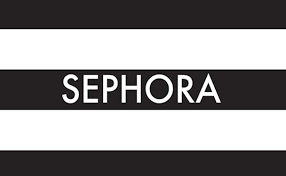

# **Purpose**

**Leveraging NLP for Enhanced Customer Insights at Sephora**

#**Methodology**
**1. Dataset Description**
The dataset comprises information gathered from the Sephora online store and user reviews specifically focused on skincare products. It encompasses over 8,000 beauty products from Sephora, including product names, brand names, prices, ingredients, ratings, and additional features. Additionally, the dataset contains user reviews for skincare products, totaling more than 1 million reviews on over 2,000 skincare items. Each review includes details such as user appearances, review ratings, review text, and review titles. The dataset serves as the foundation for conducting sentiment analysis and exploring insights related to beauty product attributes and customer feedback.

**2. Class Imbalance Handling**
To address class imbalance in the dataset, a two-step approach was implemented. Initially, oversampling was performed by duplicating a portion of the minority class instances, thereby augmenting its representation in the dataset. Subsequently, undersampling was employed to downsize the majority class, reducing its dominance in the dataset. This combined strategy aimed to create a more balanced distribution of class instances, ensuring that the model is trained on a dataset with equitable representation of both classes. By mitigating the effects of class imbalance, the model's performance and generalization capabilities were enhanced, leading to more reliable predictions and evaluations.

**3. Data Preprocessing**

It involved several key steps to refine and optimize the dataset. This included tokenization, lowercasing, punctuation removal, stop word removal for text preprocessing, and......


**Results**

The NLP project at Sephora utilizing the "prajjwal1/bert-tiny" model yielded promising results across various evaluation metrics. With a carefully selected set of hyperparameters, including a batch size of 8, a learning rate of 1e-5, and training for 3 epochs, the model demonstrated robust performance in sentiment analysis tasks. Notably, the model achieved commendable accuracy, precision, recall, and F1 score, with values of 0.8888, 0.8865, 0.8922, and 0.8893 respectively. These results indicate the effectiveness of the model in classifying sentiment within textual data. The adoption of the AdamW optimizer facilitated efficient parameter optimization during training, contributing to the model's overall performance. These outcomes underscore the efficacy of employing state-of-the-art NLP techniques, to derive actionable insights from textual data, thereby empowering Sephora to make data-driven decisions and enhance customer experiences.

**Library import**

In [ ]:
import os
import zipfile
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from IPython.display import display, Markdown
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report

 **Data import from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Sephora.zip"



'/content/drive/My Drive/Sephora.zip'


In [ ]:
# Unzip the file
!unzip "/content/drive/My Drive/Sephora.zip" -d "/content/drive/My Drive/Sephora"


Archive:  /content/drive/My Drive/Sephora.zip
replace /content/drive/My Drive/Sephora/product_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:


# List all CSV files in the 'Sephora' directory
csv_files = [file for file in os.listdir('/content/drive/My Drive/Sephora') if file.startswith('reviews') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
dfs = []

# Read each CSV file into a DataFrame and append to the list
for csv_file in csv_files:
    df_raw = pd.read_csv(os.path.join('/content/drive/My Drive/Sephora', csv_file))
    dfs.append(df_raw)

# Concatenate all DataFrames in the list along the rows axis (axis=0)
df = pd.concat(dfs, ignore_index=True)

# Print the shape of the merged DataFrame
print("Shape of merged DataFrame:", df.shape)



<ipython-input-42-fc18b6e6cdc6>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(os.path.join('/content/drive/My Drive/Sephora', csv_file))
<ipython-input-42-fc18b6e6cdc6>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(os.path.join('/content/drive/My Drive/Sephora', csv_file))
<ipython-input-42-fc18b6e6cdc6>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(os.path.join('/content/drive/My Drive/Sephora', csv_file))


Shape of merged DataFrame: (1094411, 19)


In [ ]:
# Display the first few rows of the merged DataFrame
df.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,"I use this with the Nudestix “Citrus Clean Balm & Make-Up Melt“ to double cleanse and it has completely changed my skin (for the better). The make-up melt is oil based and removes all of your makeup super easily. I follow-up with this water based cleanser, and I also use this just by itself when I’m not wearing make-up. It leaves the skin gently cleansed, but without stripping the skin. 10/10 recommend combining with the make-up melt. It’s perfection!",Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,"I bought this lip mask after reading the reviews and the hype. Unfortunately, it did not meet my expectations as vaseline petroleum jelly works way better for me.",Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited to get into bed and apply this lip mask. I do see a difference because I suffer from dry cracked lips. I drink a lot of water and apply lip balm daily but nothing helped until I started using this. untiluntistafted usinf this.,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time. I honestly don’t even use it for night time. I use it as an everyday lip balm. I love the texture. Gummy Bear is my second most favourite scent. Grapefruit is the best in my opinion.,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must have. After a few weeks of use I have learned I will always have by my bedside. I thought it was a little expensive but a little goes a long way. It is worth the price.",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitamin C,LANEIGE,24.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094411 entries, 0 to 1094410
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Unnamed: 0                1094411 non-null  int64  
 1   author_id                 1094411 non-null  object 
 2   rating                    1094411 non-null  int64  
 3   is_recommended            926423 non-null   float64
 4   helpfulness               532819 non-null   float64
 5   total_feedback_count      1094411 non-null  int64  
 6   total_neg_feedback_count  1094411 non-null  int64  
 7   total_pos_feedback_count  1094411 non-null  int64  
 8   submission_time           1094411 non-null  object 
 9   review_text               1092967 non-null  object 
 10  review_title              783757 non-null   object 
 11  skin_tone                 923872 non-null   object 
 12  eye_color                 884783 non-null   object 
 13  skin_type                 9

**Data Preprocessing**

Most unstructured text, such as reviews for products, are messy. They contain special characters which may not be necessary, extra spaces, irrelevant digits, and more. Therefore, it is common practice to process, or clean, the text before performing NLP tasks on it.



In [ ]:
missing = []
unique=[]
type=[]
variables=[]

for item in df.columns:
    variables.append(item)
    missing.append(df[item].isnull().sum())
    unique.append(df[item].nunique())
    type.append(df[item].dtype)

output=pd.DataFrame({'variables':variables,'missing':missing,'unique':unique,'type':type})

output.sort_values(by='missing',ascending=False)





,variables,missing,unique,type
4,helpfulness,561592,3767,float64
10,review_title,310654,364105,object
14,hair_color,226768,7,object
12,eye_color,209628,6,object
11,skin_tone,170539,14,object
3,is_recommended,167988,2,float64
13,skin_type,111557,4,object
9,review_text,1444,969419,object
17,brand_name,0,142,object
16,product_name,0,2334,object


In [ ]:
# Check the number of occurrences of each unique value in the 'rating' column
rating_counts = df['rating'].value_counts()

# Print the number of occurrences of each rating
print("Number of occurrences of each rating:")
print(rating_counts)


Number of occurrences of each rating:
5    698951
4    199389
3     81816
1     61223
2     53032
Name: rating, dtype: int64


In [ ]:
# Check the number of occurrences of each unique value in the 'rating' column
is_recommended_counts = df['is_recommended'].value_counts()

# Print the number of occurrences of each rating
print("Number of occurrences of each is_recommended	:")
print(is_recommended_counts)


Number of occurrences of each is_recommended	:
1.0    778160
0.0    148263
Name: is_recommended, dtype: int64


In [ ]:
# ASSUME IS RECOMMENDED TARGET TABLE
df = df[['review_text' , 'is_recommended' , 'rating']]
# change column names
df.rename(columns={'review_text':'text', 'is_recommended':'label'},  inplace=True)
df.head()

<ipython-input-48-7ebe1b000bdd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'review_text':'text', 'is_recommended':'label'},  inplace=True)


,text,label,rating
0,"I use this with the Nudestix “Citrus Clean Balm & Make-Up Melt“ to double cleanse and it has completely changed my skin (for the better). The make-up melt is oil based and removes all of your makeup super easily. I follow-up with this water based cleanser, and I also use this just by itself when I’m not wearing make-up. It leaves the skin gently cleansed, but without stripping the skin. 10/10 recommend combining with the make-up melt. It’s perfection!",1.0,5
1,"I bought this lip mask after reading the reviews and the hype. Unfortunately, it did not meet my expectations as vaseline petroleum jelly works way better for me.",0.0,1
2,My review title says it all! I get so excited to get into bed and apply this lip mask. I do see a difference because I suffer from dry cracked lips. I drink a lot of water and apply lip balm daily but nothing helped until I started using this. untiluntistafted usinf this.,1.0,5
3,I’ve always loved this formula for a long time. I honestly don’t even use it for night time. I use it as an everyday lip balm. I love the texture. Gummy Bear is my second most favourite scent. Grapefruit is the best in my opinion.,1.0,5
4,"If you have dry cracked lips, this is a must have. After a few weeks of use I have learned I will always have by my bedside. I thought it was a little expensive but a little goes a long way. It is worth the price.",1.0,5


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.describe()

,label,rating
count,924979.000000,924979.000000
mean,0.839981,4.288920
std,0.366624,1.154235
min,0.000000,1.000000
25%,1.000000,4.000000
50%,1.000000,5.000000
75%,1.000000,5.000000
max,1.000000,5.000000


In [ ]:
df.duplicated().sum()

113160

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
#Percentage of Positive/Negative
print("Positive: ", round(df.label.value_counts()[1]/len(df)*100 , 2 ),"%")
print("Negative: ", round(df.label.value_counts()[0]/len(df)*100, 2 ),"%")

Positive:  84.19 %
Negative:  15.81 %


**Class imbalance** in machine learning occurs when one class (positive) has significantly fewer instances than another class (negative) in the dataset.

- Under-sampling: This involves reducing the number of instances in the majority class to match the number of instances in the minority class.
- Over-sampling: This technique involves increasing the number of instances in the minority class to match the number of instances in the majority class.
Combination of under-sampling and over-sampling: Sometimes, a combination of both under-sampling and over-sampling techniques can be used to balance the class distribution.
-Combination of under-sampling and over-sampling: Sometimes, a combination of both under-sampling and over-sampling techniques can be used to balance the class distribution.

**Over-sampling**

In [ ]:
#SPECIFY THE DIRECTORT PATH IN GOOGLE DRIVE
directory_path = '/content/drive/My Drive/Sephora/reviews_250-500.csv'
df250 = pd.read_csv(directory_path)

In [ ]:
#select columns
df250 = df250[['review_text' , 'is_recommended' , 'rating']]
df250.rename(columns={'review_text':'text', 'is_recommended':'label'},  inplace=True)
df250.head()

,text,label,rating
0,"Used to swear by this product but hate the smell of the reformulation. Love the price, but willing to spend more for a product that doesn’t smell gross",0.0,2
1,I’ve only been using this for a week and my skin is so much softer. It’s not as “harsh” on my skin as The Ordinary’s retinol- it took some getting used to but not this one. I’m not purging and my skin isn’t drying,1.0,5
2,"Why, why, why would you change the formula?!!! I have been using this for year. It was truly amazing. Constantly getting compliments on my skin. I am 40 years old and it was perfect. I opened my new bottle and thought I got a bad one. It was rancid. Ordered a second bottle and the same. I am so upset. Why would they change it.",0.0,1
3,"I have used this product for years and it has been nothing short of awesome. Honestly, I am 44 and people think I am in my early 30s because of what this does for my skin. Hardly a wrinkle in sight. However, the latest package I bought in Feb 2023 contained serum that smelled rancid. Like spoiled milk. I tried it anyway and it felt thick and awful on my skin. I returned it to Sephora and learned that Inkey List REFORMULATED this product. I am SO upset. I really hope Inkey goes back to the old formulation because the new one is garbage.",0.0,1
4,Great product for anti-aging Also great for dark spots,1.0,5


In [ ]:
#Percentage of Positive/Negative
df250['label'].value_counts()

1.0    151316
0.0     29423
Name: label, dtype: int64

In [ ]:
#SPECIFY THE DIRECTORT PATH IN GOOGLE DRIVE
directory_path = '/content/drive/My Drive/Sephora/reviews_750-1250.csv'
df750 = pd.read_csv(directory_path)

<ipython-input-57-fbd3a4dd8072>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df750 = pd.read_csv(directory_path)


In [ ]:
#select columns
df750 = df750[['review_text' , 'is_recommended' , 'rating']]
df750.rename(columns={'review_text':'text', 'is_recommended':'label'},  inplace=True)
df750.head()

<ipython-input-58-4f1fa315ddb1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df750.rename(columns={'review_text':'text', 'is_recommended':'label'},  inplace=True)


,text,label,rating
0,"This was gifted by Supergoop! in exchange for an honest review. The packaging is nice and seems like it will prevent any powder from getting out. My issue is that it’s very hard to know how much powder you are using. Looking at the powder directly, it looks quite shimmery/glittery. On the face it looks ok. Since it is hard to know how much you have used, it is easy to use too much and for your face to look very glittery. This is something to use as a 2nd spf because you would have to use a LOT for full primary spf. I think there are easier ways to reapply spf.",0.0,2
1,I didn’t like it; too much product comes out without turning it,0.0,2
2,"Y’all….I’m begging for everyone to read instructions. When you initially take this out of the package it will have a yellow tube in the middle of the brush holding in the powder. You need to take a pair of tweezers or something to pull it out. Once you pull it out the powder is now loose and you can twist the bottom, holding the brush upside down, and powder will fill the brush. I usually use this for touch ups in the summer. It is definitely not full coverage, just something to slip in the bag and take out for a nice touch of extra SPF. It’s not a powder foundation, nor will it super set your makeup. This is purely for touch ups after applying a good spf before makeup. I personally love it, it’s not messy and the cap holds on in my bag. It’s small enough to take to theme parks in the summer, or out by the beach. If you simply use it for touch ups it will last a very long time, if you are looking for an everyday, heavy duty powder - look for bare minerals or something that has SPF in it with bigger packaging/more coverage.",1.0,5
3,I have not figured out how to use this product up to now. I’ve been trying for the last couple of days without luck. Product not for me,0.0,1
4,"I’m at a loss as to how to use this thing!!! Confusing instructions, can’t get product out, can’t use it. A real bummer!!",0.0,1


In [ ]:
#Percentage of Positive/Negative
df750['label'].value_counts()

1.0    94797
0.0    15624
Name: label, dtype: int64

In [ ]:
# Concat both Dataframe based on Negative review ,and take negative ones
df_conct = pd.concat([df250, df750], axis=0) #  axis=0 ,staking on top of each other.
# selecting rows based on condition
df_neg = df_conct[df_conct['label'] == 0]

df_neg['label'].value_counts()

0.0    45047
Name: label, dtype: int64

In [ ]:
#concatenate dataframe by negative
df = pd.concat([df, df_neg])
df['label'].value_counts()

1.0    683450
0.0    173416
Name: label, dtype: int64

In [ ]:
#Percentage of Positive/Negative
print("Positive: ", round(df.label.value_counts()[1]/len(df)*100 , 2 ),"%")
print("Negative: ", round(df.label.value_counts()[0]/len(df)*100, 2 ),"%")

Positive:  79.76 %
Negative:  20.24 %


**Under Sampling - downsize the Majority class**

Selects all rows with label 0 (negative class) into df_neg. Then, it samples the same number of instances from the positive class (label 1) using the sample() function, ensuring that the same number of instances is taken from the positive class as there are in the negative class

In [ ]:
# Calculate the number of instances for each class to achieve 50% positive and 50% negative
 #calculate the minimum number of instances among positive and negative classes. This ensures that we sample an equal number of instances from each class to achieve a balanced dataset.
num_instances = min(df['label'].value_counts())

#he sample() function to randomly select num_instances instances from both positive and negative classes. The replace=True parameter allows sampling with replacement, meaning some instances might be selected multiple times, ensuring that both classes have the same number of instances.
# Sample equal number of instances for each class
df_pos = df[df['label'] == 1].sample(n=num_instances, replace=True)
df_neg = df[df['label'] == 0].sample(n=num_instances, replace=True)

# Merge the positive and negative class samples into a single DataFrame
balanced_df = pd.concat([df_pos, df_neg])

# Shuffle the rows of the merged DataFrame
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Percentage of Positive/Negative in the balanced DataFrame
print("Positive: ", round(balanced_df['label'].value_counts()[1]/len(balanced_df)*100, 2), "%")
print("Negative: ", round(balanced_df['label'].value_counts()[0]/len(balanced_df)*100, 2), "%")


Positive:  50.0 %
Negative:  50.0 %


dataset currently has a balanced distribution of reviews, so we can proceed with the data exploration-Cleaning Data


In [ ]:
#Checking null values
balanced_df.isnull().sum()

text      56
label      0
rating     0
dtype: int64

In [ ]:
balanced_df.dropna(inplace=True)


In [ ]:
#Convert single column to int dtype.
balanced_df['label'] = balanced_df['label'].astype('int')
# ensure the casting happened
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346832 entries, 0 to 346831
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    346776 non-null  object
 1   label   346832 non-null  int64 
 2   rating  346832 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


In [ ]:
pd.set_option('display.max_colwidth', None)
balanced_df.head(2)

,text,label,rating
0,i really saw such a difference in my skin after using this! there’s no fragrance which is a plus since i’m very sensitive to fragrance in skincare products. my blemishes went away after a few times using this! definitely recommend,1,5
1,"Weird, watery formula with too much fragrance for my liking. I said appreciate how emollient it was on my dry skin - it felt nice. I would not recommend based on the watery consistency (did not wear well under my makeup) and the fragrance. If those things don’t bother you, then this is a good sunscreen that gets the job done.",0,3


# Visualize Data

In [ ]:
balanced_df['label'].value_counts()

1    173416
0    173416
Name: label, dtype: int64

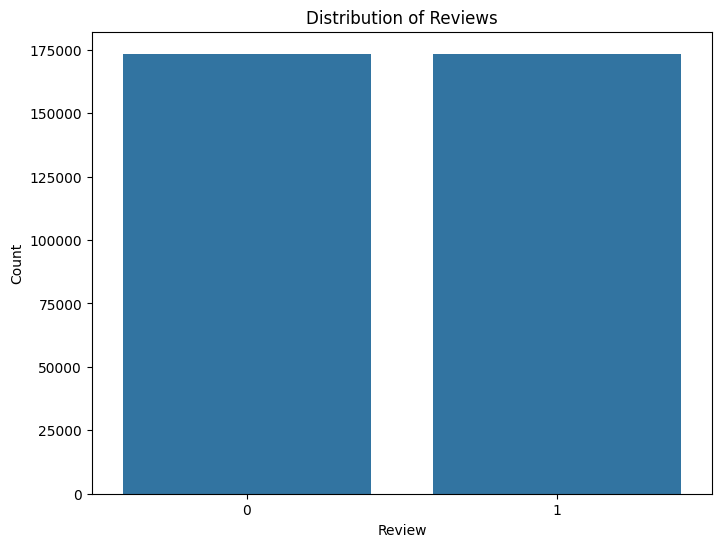

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=balanced_df)
plt.title('Distribution of Reviews')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

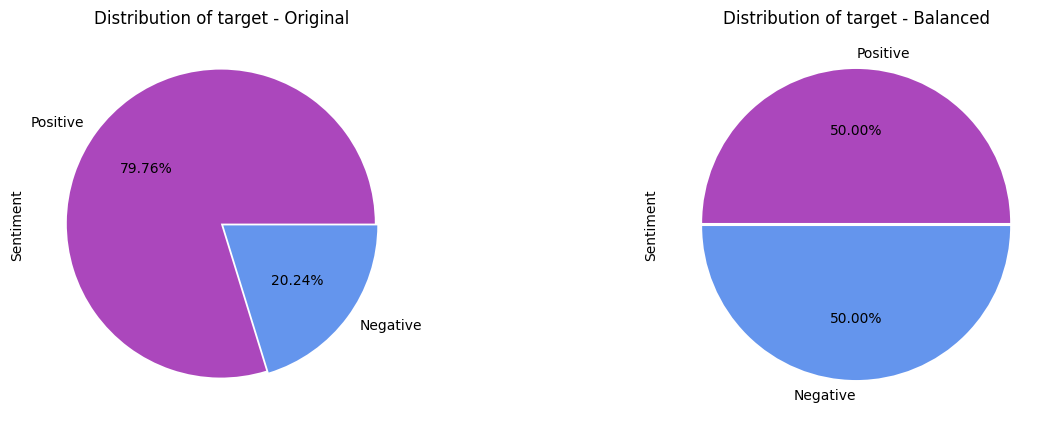

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first pie chart for the original DataFrame 'df'
colors = ['#AB47BC', '#6495ED']
axs[0].pie(df['label'].value_counts(), labels=['Positive', 'Negative'], autopct='%.2f%%', explode=[0.01, 0.01], colors=colors)
axs[0].set_title('Distribution of target - Original')
axs[0].set_ylabel('Sentiment')

# Plot the second pie chart for the balanced DataFrame 'balanced_df'
axs[1].pie(balanced_df['label'].value_counts(), labels=['Positive', 'Negative'], autopct='%.2f%%', explode=[0.01, 0.01], colors=colors)
axs[1].set_title('Distribution of target - Balanced')
axs[1].set_ylabel('Sentiment')

plt.show()


In [ ]:
balanced_df['text'] = balanced_df['text'].fillna('')



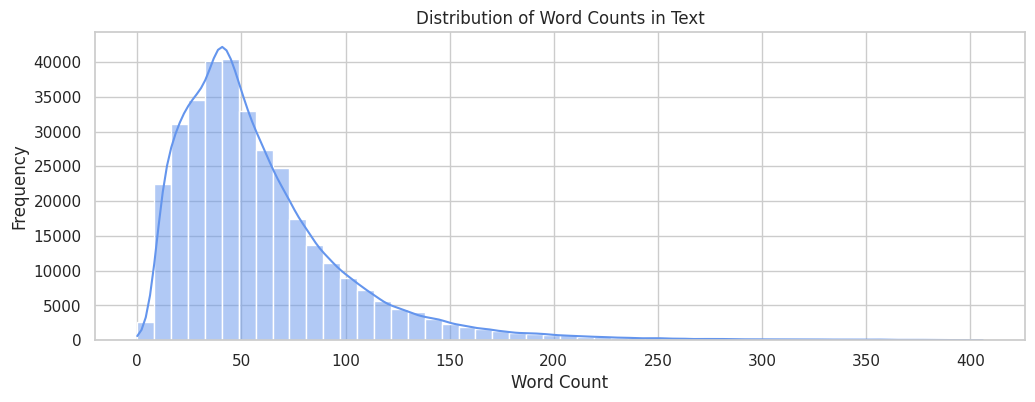

In [ ]:
# Add a new column 'text_word_count' containing the number of words in each text
balanced_df['text_word_count'] = balanced_df['text'].apply(lambda x: len(x.split()))

# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the distribution of word counts
plt.figure(figsize=(12, 4))
sns.histplot(data=balanced_df, x='text_word_count', bins=50, color='#6495ED', kde=True)
plt.title("Distribution of Word Counts in Text")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


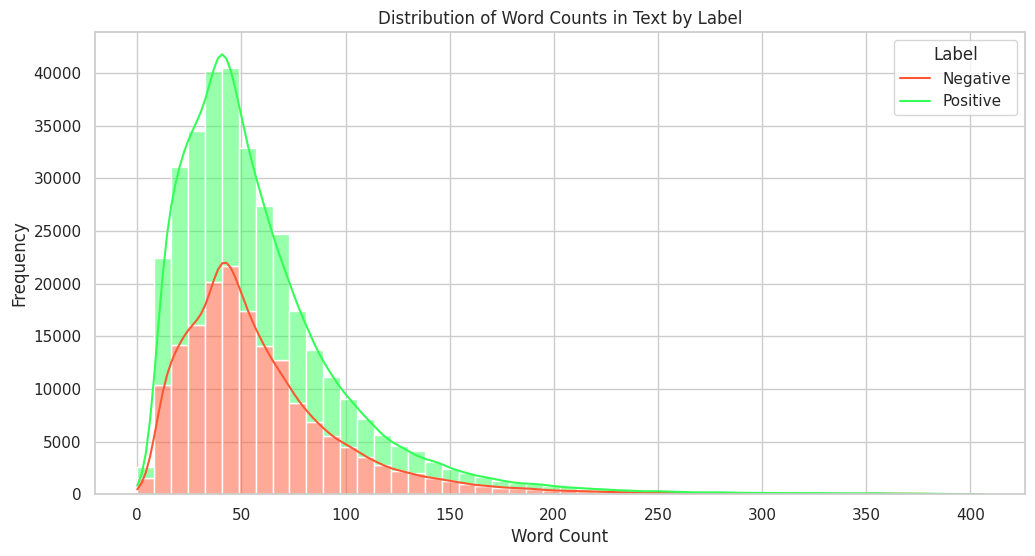

In [ ]:

# Add a new column 'text_word_count' containing the number of words in each text
balanced_df['text_word_count'] = balanced_df['text'].apply(lambda x: len(x.split()))

# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom colors for each class
custom_colors = {0: '#33FF57', 1: '#FF5733'}  # Red for negative, green for positive

# Plot the distribution of word counts with hue for labels
plt.figure(figsize=(12, 6))
sns.histplot(data=balanced_df, x='text_word_count', bins=50, hue='label', multiple="stack", palette=custom_colors, kde=True)
plt.title("Distribution of Word Counts in Text by Label")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title="Label", labels=['Negative', 'Positive'])
plt.show()


# **Text pre-processing **

In [ ]:
# Before preprocessing
print("Before Preprocessing:")
print(balanced_df.iloc[2])

Before Preprocessing:
text               I basically purchased this oil for it’s vitamin C and turmeric benefits for skim brightening and treating some of my hyperpigmentation. Although I liked the product in the sense that it felt good on my skin and kept me hydrated but unfortunately I did not see any of brightening or vitamin C advantage of it. I used the whole bottle and applied it religiously for 3 months, every morning but saw nothing. My 20$ vitamin c serum which I was using before this helped me more than this. Also vitamin C is way down the product list.
label                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
#remove extra characters
balanced_df['text']=balanced_df['text'].str.replace('[^\w\s]','')

<ipython-input-75-20e2a22e61d8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df['text']=balanced_df['text'].str.replace('[^\w\s]','')


In [ ]:
from bs4 import BeautifulSoup

# Define strip_html function
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
# Apply strip_html function to the 'text' column
balanced_df['text'] = balanced_df['text'].apply(strip_html)

In [ ]:
def remove_between_square_brackets(text):
    # Regular expression to remove text between square brackets
    return re.sub(r'\[.*?\]', '', text)

In [ ]:
# Define denoise_text function
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Apply denoise_text function to the 'text' column
balanced_df['text'] = balanced_df['text'].apply(denoise_text)

In [ ]:
#remove digit
balanced_df['text']=balanced_df['text'].str.replace(r'\d+', '')

<ipython-input-80-282960dd7a1d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df['text']=balanced_df['text'].str.replace(r'\d+', '')


In [ ]:
#remove running spaces
balanced_df['text']=balanced_df['text'].str.replace(r'^\s+|\s+$', '')

<ipython-input-81-d3b497210d21>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df['text']=balanced_df['text'].str.replace(r'^\s+|\s+$', '')


In [ ]:
#remove running special_characters
balanced_df['text']=balanced_df['text'].str.replace(r'[^a-zA-z0-9\s]', '')

<ipython-input-82-971d9185d47f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  balanced_df['text']=balanced_df['text'].str.replace(r'[^a-zA-z0-9\s]', '')


In [ ]:
#make the text lowercase
balanced_df['text']=balanced_df['text'].str.lower()

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
balanced_df['text']=balanced_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Remove leading and trailing spaces
balanced_df['text']=balanced_df['text'].str.strip()

In [ ]:
import nltk
from nltk.stem import PorterStemmer

# Define the simple_stemmer function
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_text = ' '.join([ps.stem(word) for word in text.split()])
    return stemmed_text


# Apply the simple_stemmer function to the 'text' column
balanced_df['text'] = balanced_df['text'].apply(simple_stemmer)


In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
balanced_df['text'] =balanced_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import re

# Define the remove_repeated_chars function
def remove_repeated_chars(text):
    # Define the regex pattern to match consecutive repeated characters
    pattern = re.compile(r'(.)\1{2,}')  # Matches 2 or more consecutive repetitions of the same character

    # Replace consecutive repeated characters with a single occurrence
    cleaned_text = pattern.sub(r'\1', text)

    return cleaned_text

# Apply the remove_repeated_chars function to the 'text' column
balanced_df['text'] = balanced_df['text'].apply(remove_repeated_chars)


In [ ]:
# After preprocessing
balanced_df['text_word_count'] = balanced_df['text'].apply(lambda x: len(x.split()))
print("\nAfter Preprocessing:")
print(balanced_df.iloc[2])


After Preprocessing:
text               basic purchas oil vitamin c turmer benefit skim brighten treat hyperpigment although like product sen felt good skin kept hydrat unfortun see brighten vitamin c advantag use whole bottl appli religi month everi morn saw noth vitamin c serum use help also vitamin c way product list
label                                                                                                                                                                                                                                                                                                      0
rating                                                                                                                                                                                                                                                                                                     2
text_word_count                                                            

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 856866 entries, 0 to 119248
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    856808 non-null  object 
 1   label   856866 non-null  float64
 2   rating  856866 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 26.1+ MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/NLP"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the DataFrame to a CSV file
balanced_df.to_csv('balanced_df.csv', index=False)


In [ ]:
balanced_df.head(5)

,text,label,rating,text_word_count
0,realli saw differ skin use there fragranc plu sinc im sensit fragranc skincar product blemish went away time use definit recommend,1,5,21
1,weird wateri formula much fragranc like said appreci emolli dri skin felt nice would recommend base wateri consist wear well makeup fragranc thing dont bother good sunscreen get job done,0,3,30
2,basic purchas oil vitamin c turmer benefit skim brighten treat hyperpigment although like product sen felt good skin kept hydrat unfortun see brighten vitamin c advantag use whole bottl appli religi month everi morn saw noth vitamin c serum use help also vitamin c way product list,0,2,47
3,product obvious bit pricey love smell great amaz light airi whip textur calm hydrat skin make break moisturis order second contain,1,5,21
4,unfortun product irrit skin first use think fairli toler skin experienc burn sensat face product took back sephora employe said wasnt uncommon complaint peopl love basic didnt work lot peopl rave,0,1,31


**Train | Validation | Test Sets**

In [ ]:
 from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (90% training, 10% test)
train_data, test_data = train_test_split(balanced_df, test_size=0.1, random_state=42)

# Split the training data into training and validation sets (80% training, 20% validation)
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Display the sizes of the datasets
print("Training data size:", len(train_data))
print("Validation data size:", len(validation_data))
print("Test data size:", len(test_data))


Training data size: 249718
Validation data size: 62430
Test data size: 34684


**Initialize Tiny-BERT Model and Tokenize**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from tensorflow.keras.callbacks import ModelCheckpoint

#model_name = "bert-base-uncased"
#tokenizer = BertTokenizer.from_pretrained(model_name)
#model = BertForSequenceClassification.from_pretrained(model_name)
# Load DistilBERT tokenizer and model
#model_name = "distilbert-base-uncased"
#tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#model = DistilBertForSequenceClassification.from_pretrained(model_name)


model_name = "prajjwal1/bert-tiny"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 #Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='model_checkpoint_{epoch}.h5', save_best_only=False)

In [ ]:
# Define hyperparameters
batch_size = 8
learning_rate = 1e-5
epochs = 3
max_length = 128
patience = 3

In [ ]:
# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='model_checkpoint1_{epoch}.h5',
                             monitor='val_loss',
                             save_best_only=False,
                             mode='auto')

In [ ]:
# Display the sizes of the datasets
print("Training data size:", len(train_data))

Training data size: 249674


In [ ]:
!nvidia-smi

Mon Mar 18 16:33:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Tokenize the input data using the tokenizer

train_inputs = tokenizer(train_data['text'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
train_labels = torch.tensor(train_data['label'].tolist())

validation_inputs = tokenizer(validation_data['text'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
validation_labels = torch.tensor(validation_data['label'].tolist())



In [ ]:
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = TensorDataset(validation_inputs['input_ids'], validation_inputs['attention_mask'], validation_labels)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

**Define Optimizer**

In [ ]:

# Define the optimizer for training the mode

optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

In [ ]:
# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    num_batches = len(train_dataloader)
    with tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataloader:
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.update(1)  # Update progress bar
            pbar.set_postfix({'loss': train_loss / (num_batches+1)})  # Update loss in progress bar


Epoch 3/3: 100%|██████████| 31215/31215 [26:21<00:00, 19.74batch/s, loss=0.282]


In [ ]:
# Validation
model.eval()
val_loss = 0
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        val_loss += loss.item()

# Compute average validation loss
avg_val_loss = val_loss / len(validation_dataloader)
print(f'Validation Loss: {avg_val_loss}')


Validation Loss: 0.27074665502641015


In [ ]:
torch.save(model.state_dict(), 'model_checkpoint1.pth')

In [ ]:
# Load the saved model's state dictionary
state_dict = torch.load('model_checkpoint1.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [ ]:
# Tokenize test_data
test_inputs = tokenizer(test_data['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
test_labels = torch.tensor(test_data['label'].tolist())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Create a PyTorch DataLoader for the test dataset
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Lists to store true labels and predicted labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

# Iterate over batches of test data
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Convert logits to predicted labels
        batch_predictions = torch.argmax(logits, dim=1)
        # Append true and predicted labels to lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(batch_predictions.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8888536500980279
Precision: 0.8864663805436338
Recall: 0.8922359175210229
F1 Score: 0.8893417917731148


In [ ]:

index_test =1
text = test_data["text"].iloc[index_test]
actual_label = test_data["label"].iloc[index_test]

# Print the text and actual label
print("Test Data Record:")
print("Text:", text)
print("Actual Label:", actual_label)

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Print the predicted label
print("Predicted Label:", predicted_label)


Test Data Record:
Text: receiv moistur gift innisfre exchang opinion absorb well skin combin skin suitabl use summer winter may moistur enough
Actual Label: 1
Predicted Label: 1


In [ ]:

index_test =40
text = test_data["text"].iloc[index_test]
actual_label = test_data["label"].iloc[index_test]

# Print the text and actual label
print("Test Data Record:")
print("Text:", text)
print("Actual Label:", actual_label)

# Tokenize the text
inputs = tokenizer(text, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Print the predicted label
print("Predicted Label:", predicted_label)


Test Data Record:
Text: product alway pill matter wear ive tri everi way could think still sit top skin ball blend touch face appreci clean ingredi brand make good product would pas one
Actual Label: 0
Predicted Label: 0


**Inference**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the pretrained tokenizer and model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load the saved model's state dictionary
state_dict = torch.load('model_checkpoint1.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Example test data
test_text = "love moistur much make skin feel hydrat smooth clog pore caus breakout kept skin soft nourish day long would definit recommend"

# Tokenize the test text
inputs = tokenizer(test_text, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label
predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Output the prediction
print("Predicted label:", predicted_label)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: 1
